In [70]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)


# Only using currently registered AP

In [71]:
# Read in Data and set it up
data = pd.read_csv('./testingProcess/processed_test4.txt')
data = data.drop_duplicates()
data = data[data['mPci'] > 0]
data = data[data['mRegistered'] == "YES"]
data = data.sort_values(by=['mTimeStamp'])

# Create Column to find if handover occurec
data['nextAP'] = data['mPci'].shift(-1)
data = data[:-1]
def label_handover_occured(row):
    if row['mPci'] == row['nextAP']:
        return 0
    return 1
data['handoverOccured'] = data.apply(lambda row: label_handover_occured(row), axis=1)

# Creating Training Data
data_X = []
data_Y = []
number_samples = 5
for index in range(0, len(data)-number_samples):
    dataframe = data.iloc[index:index+number_samples]
    dataframe = dataframe[['rsrq', 'handoverOccured']]
    data_X.append(dataframe['rsrq'].tolist())
    data_Y.append(dataframe.iloc[number_samples-1]['handoverOccured'])

print("Example Data at Index 0:")
print("X: " + str(data_X[0]))
print("Y: " + str(data_Y[0]))

Example Data at Index 0:
X: [-15, -9, -6, -7, -11]
Y: 0


Balanced Weighted Logistic Regression
Count of 0's in Training: 191
Count of 1's in Training: 19
True Positive Rate: 72.73%
True Negative Rate: 65.59%
Tensorflow NN - 1 Layer
Weight for class 0: 1.05
Weight for class 1: 10.55
Epoch 1/2
53/53 [==============================] - 0s 1ms/step - loss: 1.3495 - accuracy: 0.2952
Epoch 2/2
53/53 [==============================] - 0s 1ms/step - loss: 1.3348 - accuracy: 0.5000
True Positive Rate: 100.00%
True Negative Rate: 0.00%


<ipython-input-72-f69c3f91d0c4>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


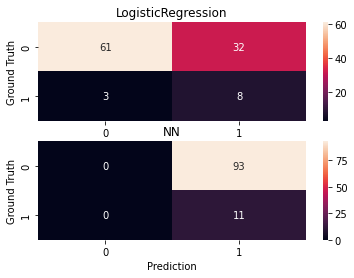

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)
fig, ax  = plt.subplots(2,1)
############################
# Weighted Logistic Regression
############################
print("Balanced Weighted Logistic Regression")
count_0 = y_train.count(0)
count_1 = y_train.count(1)
print("Count of 0's in Training: " + str(count_0))
print("Count of 1's in Training: " + str(count_1))
w = {0: count_1, 1: count_0}
clf = LogisticRegression(random_state=0, class_weight=w).fit(X_train, y_train)
# Make Predictions
predictions = clf.predict(X_test)
# Calculate Metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# TPR
TPR = tp / (tp + fn)
print(f"True Positive Rate: {TPR:2.2%}")
# TNR
TNR = tn / (tn + fp)
print(f"True Negative Rate: {TNR:2.2%}")
s = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax=ax[0])
s.set(xlabel='Prediction', ylabel='Ground Truth', title="LogisticRegression")

############################
# Tensorflow NN
############################
print("Tensorflow NN - 1 Layer")
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
weight_for_0 = (1 / count_0) * (count_0 + count_1 / 2.0)
weight_for_1 = (1 / count_1) * (count_0 + count_1 / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
model.fit(np.asarray(X_train), np.asarray(y_train), epochs=2, batch_size=4, class_weight=class_weight)
# Make Predictions
raw_predictions = model.predict(np.asarray(X_test))
predictions = []
for i in raw_predictions:
    if (i < 0.5):
        predictions.append(0)
    else:
        predictions.append(1)
# Calculate Metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# TPR
TPR = tp / (tp + fn)
print(f"True Positive Rate: {TPR:2.2%}")
# TNR
TNR = tn / (tn + fp)
print(f"True Negative Rate: {TNR:2.2%}")
sa = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax=ax[1])
sa.set(xlabel='Prediction', ylabel='Ground Truth', title="NN")
fig.show()


In [73]:
# Add variable for timestamp instead of using the next row

# Include ss, rsrp, rsrq
# Include best neighboring cell's values
# rsrp = -60 is good but potential threshold is =-100

# Keep X input dimension combination of features
# Different Handover windows based on accuracies - shorter may be easier?

# Use Registered AP with SS and other variables

In [74]:
# Read in Data and set it up
data = pd.read_csv('./testingProcess/processed_test4.txt')
data = data.drop_duplicates()
data = data[data['mPci'] > 0]
data = data[data['mRegistered'] == "YES"]
data = data.sort_values(by=['mTimeStamp'])

# Create Column to find if handover occurec
data['nextAP'] = data['mPci'].shift(-1)
data = data[:-1]


def label_handover_occured(row):
    if row['mPci'] == row['nextAP']:
        return 0
    return 1


data['handoverOccured'] = data.apply(
    lambda row: label_handover_occured(row), axis=1)

# Creating Training Data
data_X = []
data_Y = []
number_samples = 5
for index in range(0, len(data)-number_samples):
    dataframe = data.iloc[index:index+number_samples]
    datapoint = []
    for i in range(number_samples):
        datapoint.append(dataframe.iloc[i]['ss'])
        datapoint.append(dataframe.iloc[i]['rsrp'])
        # datapoint.append(dataframe.iloc[i]['rsrq'])
    data_X.append(datapoint)
    data_Y.append(dataframe.iloc[number_samples-1]['handoverOccured'])

print("Example Data at Index 0:")
print("X: " + str(data_X[0]))
print("Y: " + str(data_Y[0]))


Example Data at Index 0:
X: [31, -64, 31, -67, 31, -65, 31, -76, 31, -76]
Y: 0


Balanced Weighted Logistic Regression
Count of 0's in Training: 191
Count of 1's in Training: 19
True Positive Rate: 54.55%
True Negative Rate: 75.27%
Tensorflow NN - 1 Layer
Weight for class 0: 1.05
Weight for class 1: 10.55
Epoch 1/2
53/53 [==============================] - 0s 2ms/step - loss: 1.5344 - accuracy: 0.5000
Epoch 2/2
53/53 [==============================] - 0s 2ms/step - loss: 1.4324 - accuracy: 0.5143
True Positive Rate: 45.45%
True Negative Rate: 62.37%


<ipython-input-76-56246358388b>:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


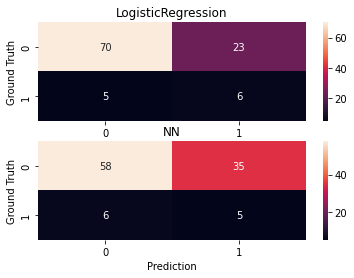

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_Y, test_size=0.33, random_state=42)
fig, ax = plt.subplots(2, 1)
############################
# Weighted Logistic Regression
############################
print("Balanced Weighted Logistic Regression")
count_0 = y_train.count(0)
count_1 = y_train.count(1)
print("Count of 0's in Training: " + str(count_0))
print("Count of 1's in Training: " + str(count_1))
w = {0: count_1, 1: count_0}
clf = LogisticRegression(random_state=0, class_weight=w).fit(X_train, y_train)
# Make Predictions
predictions = clf.predict(X_test)
# Calculate Metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# TPR
TPR = tp / (tp + fn)
print(f"True Positive Rate: {TPR:2.2%}")
# TNR
TNR = tn / (tn + fp)
print(f"True Negative Rate: {TNR:2.2%}")
s = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax=ax[0])
s.set(xlabel='Prediction', ylabel='Ground Truth', title="LogisticRegression")

############################
# Tensorflow NN
############################
print("Tensorflow NN - 1 Layer")
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
weight_for_0 = (1 / count_0) * (count_0 + count_1 / 2.0)
weight_for_1 = (1 / count_1) * (count_0 + count_1 / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
model.fit(np.asarray(X_train), np.asarray(y_train),
          epochs=2, batch_size=4, class_weight=class_weight)
# Make Predictions
raw_predictions = model.predict(np.asarray(X_test))
predictions = []
for i in raw_predictions:
    if (i < 0.5):
        predictions.append(0)
    else:
        predictions.append(1)
# Calculate Metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# TPR
TPR = tp / (tp + fn)
print(f"True Positive Rate: {TPR:2.2%}")
# TNR
TNR = tn / (tn + fp)
print(f"True Negative Rate: {TNR:2.2%}")
sa = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax=ax[1])
sa.set(xlabel='Prediction', ylabel='Ground Truth', title="NN")
fig.show()


# Compare best non-registered vs registered

In [88]:
# Read in Data and set it up
data = pd.read_csv('./testingProcess/processed_test4.txt')
data = data.drop_duplicates()
data = data[data['mPci'] > 0]
data = data[data['mRegistered'] == "YES"]
data = data.sort_values(by=['mTimeStamp'])

# Create Column to find if handover occurec
data['nextAP'] = data['mPci'].shift(-1)
data = data[:-1]

def label_handover_occured(row):
    if row['mPci'] == row['nextAP']:
        return 0
    return 1

data['handoverOccured'] = data.apply(
    lambda row: label_handover_occured(row), axis=1)

handover_list = data['handoverOccured'].tolist()

In [89]:
# Read in Data and set it up
data = pd.read_csv('./testingProcess/processed_test4.txt')
data = data.drop_duplicates()
data = data[data['mPci'] > 0]
data = data.sort_values(by=['mTimeStamp'])
data.head(10)


,mRegistered,mTimeStamp,mPci,mTac,mEarfcn,mMcc+mMnc,ss,rsrp,rsrq,rssnr,cqi,ta
0,YES,60773417766871,192,16175,675,310260,31,-64,-15,2147483647,2147483647,2147483647
1,NO,60773417766871,179,2147483647,675,nullnull,28,-86,-18,2147483647,2147483647,2147483647
14,YES,60775480278066,192,16175,675,310260,31,-67,-9,2147483647,2147483647,2147483647
15,NO,60775480278066,179,2147483647,675,nullnull,28,-86,-18,2147483647,2147483647,2147483647
34,YES,60777989277899,192,16175,675,310260,31,-65,-6,2147483647,2147483647,2147483647
35,NO,60777989277899,179,2147483647,675,nullnull,28,-86,-18,2147483647,2147483647,2147483647
50,YES,60780100909776,192,16175,675,310260,31,-76,-7,2147483647,2147483647,2147483647
51,NO,60780100909776,179,2147483647,675,nullnull,27,-92,-20,2147483647,2147483647,2147483647
54,YES,60780500794035,192,16175,675,310260,31,-76,-11,2147483647,2147483647,2147483647
55,NO,60780500794035,179,2147483647,675,nullnull,27,-92,-20,2147483647,2147483647,2147483647


In [90]:
timestamp_list = np.unique(data['mTimeStamp'].tolist())
data_X = []
data_Y = handover_list
for time in timestamp_list:
    selected_row = data[data['mTimeStamp']==time]
    registered = selected_row[selected_row['mRegistered']=="YES"]
    non_registered = selected_row[selected_row['mRegistered']=="NO"]
    # non_registered['TotalSum'] = non_registered['rsrp'] + non_registered['rsrq']
    non_registered['TotalSum'] = non_registered['rsrp']
    if(len(non_registered) == 0):
        datapoint = [registered.iloc[0]['ss'], registered.iloc[0]['rsrp'], registered.iloc[0]['rsrq'], 0, 0, 0]
    else:
        datapoint = [registered.iloc[0]['ss'], registered.iloc[0]['rsrp'], registered.iloc[0]['rsrq'], non_registered.iloc[0]['ss'], non_registered.iloc[0]['rsrp'], non_registered.iloc[0]['rsrq']]
    data_X.append(datapoint)


/Users/Parth/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [91]:
print(data_X[28])
print(data_Y[28])

[30, -90, -17, 0, 0, 0]
1


Balanced Weighted Logistic Regression
Count of 0's in Training: 195
Count of 1's in Training: 18
True Positive Rate: 38.46%
True Negative Rate: 67.74%
Tensorflow NN - 1 Layer
Weight for class 0: 1.05
Weight for class 1: 11.33
Epoch 1/2
54/54 [==============================] - 0s 1ms/step - loss: 57.5002 - accuracy: 0.9155
Epoch 2/2
54/54 [==============================] - 0s 1ms/step - loss: 29.1461 - accuracy: 0.9155
True Positive Rate: 0.00%
True Negative Rate: 100.00%


<ipython-input-93-ef7034283381>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


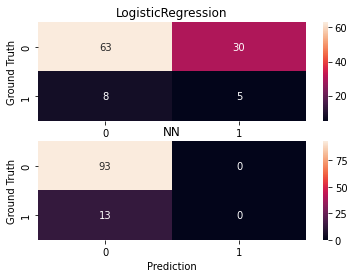

In [93]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)
fig, ax  = plt.subplots(2,1)
############################
# Weighted Logistic Regression
############################
print("Balanced Weighted Logistic Regression")
count_0 = y_train.count(0)
count_1 = y_train.count(1)
print("Count of 0's in Training: " + str(count_0))
print("Count of 1's in Training: " + str(count_1))
w = {0: count_1, 1: count_0}
clf = LogisticRegression(random_state=0, class_weight=w).fit(X_train, y_train)
# Make Predictions
predictions = clf.predict(X_test)
# Calculate Metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# TPR
TPR = tp / (tp + fn)
print(f"True Positive Rate: {TPR:2.2%}")
# TNR
TNR = tn / (tn + fp)
print(f"True Negative Rate: {TNR:2.2%}")
s = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax=ax[0])
s.set(xlabel='Prediction', ylabel='Ground Truth', title="LogisticRegression")

############################
# Tensorflow NN
############################
print("Tensorflow NN - 1 Layer")
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
weight_for_0 = (1 / count_0) * (count_0 + count_1 / 2.0)
weight_for_1 = (1 / count_1) * (count_0 + count_1 / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
model.fit(np.asarray(X_train), np.asarray(y_train), epochs=2, batch_size=4, class_weight=class_weight)
# Make Predictions
raw_predictions = model.predict(np.asarray(X_test))
predictions = []
for i in raw_predictions:
    if (i < 0.5):
        predictions.append(0)
    else:
        predictions.append(1)
# Calculate Metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# TPR
TPR = tp / (tp + fn)
print(f"True Positive Rate: {TPR:2.2%}")
# TNR
TNR = tn / (tn + fp)
print(f"True Negative Rate: {TNR:2.2%}")
sa = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax=ax[1])
sa.set(xlabel='Prediction', ylabel='Ground Truth', title="NN")
fig.show()